# Importing libraries

In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm

# Importing dataset

In [2]:
dataset = pd.read_csv('Sales_data.csv')

In [3]:
# look into dataset structure
dataset.head()

,Date,Sales,Units,Stock,SKU,Retailer
0,2014-02-06,0.0,NaN,-0.0,SKU_126,RETAILER_5
1,2014-02-06,0.0,NaN,0.0,SKU_126,RETAILER_6
2,2014-02-06,0.0,NaN,0.0,SKU_126,RETAILER_7
3,2014-02-06,0.0,NaN,0.0,SKU_126,RETAILER_8
4,2014-02-06,0.0,NaN,0.0,SKU_127,RETAILER_0


# Data preprocessing

In [4]:
# find min. and max. dates in 'Date' column
dataset['Date'].min(), dataset['Date'].max()

('2014-02-06', '2017-10-19')

In [5]:
# Since 'Sales_data.csv' contains additional columns Units, Stock, SKU and Retailer
# and there is no information on their influence on sales, they are not concidered on further model building process
# negative values in sales column remained, assuming they reflect product rerurns by customer
X = dataset.iloc[:, 0:2]

In [6]:
len(X)

114199

In [7]:
X.tail()

,Date,Sales
114194,2017-10-19,0.0
114195,2017-10-19,-0.9
114196,2017-10-19,0.0
114197,2017-10-19,0.0
114198,2017-10-19,0.0


In [8]:
# check how many columns have nan values
X.isnull().sum()

Date     0
Sales    0
dtype: int64

In [9]:
# since task is to predict sales for next 6 months, the sales data is groupped by Date
X = X.groupby('Date')['Sales'].sum().reset_index()

In [10]:
X

,Date,Sales
0,2014-02-06,272996.20
1,2014-02-13,346172.76
2,2014-02-20,423308.32
3,2014-02-27,387812.84
4,2014-03-05,528118.23
...,...,...
189,2017-09-21,504333.40
190,2017-09-28,490658.09
191,2017-10-05,471625.42
192,2017-10-12,448425.58


In [11]:
# fill in nan values in case if any with 0
X.fillna(X.dtypes.replace({'float64': 0.0}), downcast='infer', inplace=True)

In [12]:
# change values to date time in columns with date
format = '%Y-%m-%d %H:%M:%S'
X['Date'] = pd.to_datetime(X['Date'] + ' 00:00:00', format=format)
X = X.set_index(pd.DatetimeIndex(X['Date']))

In [13]:
# remove duplicates 'Date' column
X = X.drop('Date', 1)

<ipython-input-13-44f36e5438dc>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = X.drop('Date', 1)


In [14]:
# since task is to make predictions for next 6 months and since current date data is patchy
# average daily sales value for month will be used, and start of each month is used as timestamp
y = X['Sales'].resample('MS').mean()

In [15]:
y['2014']

Date
2014-02-01    357572.5300
2014-03-01    545586.2550
2014-04-01    425795.8260
2014-05-01    515080.1250
2014-06-01    662039.0300
2014-07-01    576231.1880
2014-08-01    669782.2150
2014-09-01    449120.1025
2014-10-01    398807.1140
2014-11-01    433800.2075
2014-12-01    438041.5960
Freq: MS, Name: Sales, dtype: float64

# Visualizing the Sales Time Series Data

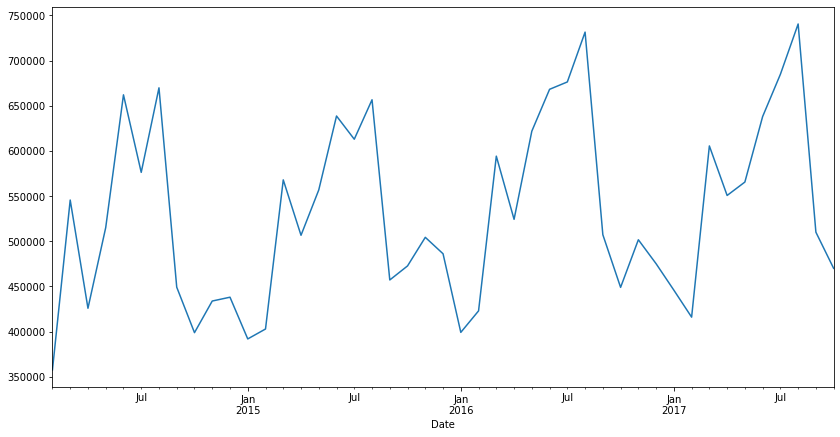

In [16]:
# plot and display our dataset
y.plot(figsize=(14, 7))
plt.show()

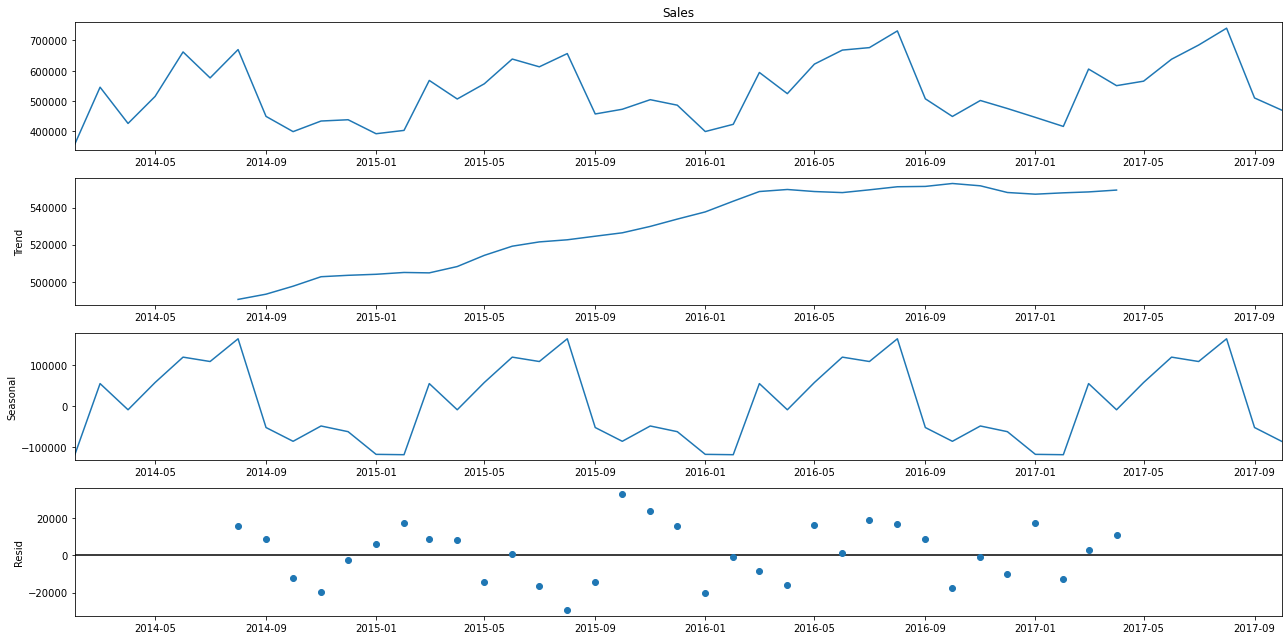

In [17]:
# since data shows obvious seasonality, whith decrease of sales starting from September and continues 
# up untill March (which happens in industries like icecream production or agriculture),
# it would be good to visualize separatly data in terms of seasonality, trend and noise
# such visualization implemented with time-series decomposition method

# set chart size
rcParams['figure.figsize'] = 18, 9
# using time-series decomposition method, build charts
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

Above provided charts, proves that company's sales show continues positive growth dynamics, with clear seasonality.

## Time series forecasting with ARIMA

In [18]:
# time-series forecasting done with ARIMA method
# set range for ARIMA model parameters
p = d = q = range(0, 2)
# generate the list of parameters combinations
pdq = list(itertools.product(p, d, q))
# generate the list of seasonal parameters combinations
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# display the examples of generated combinations
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [19]:
# find optimal set of parameters (combinations) that wil give best model performance using grid search

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(maxiter=200)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1289.1262043298486
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3022756.568816093
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:772.3314040252706
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:481.52248331779117
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:787.5348963557394
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2855604.0039792806
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:504.0825160593145
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:477.030817856701
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1231.04070951979
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2652758.4389155465
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:740.7322835462868
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:456.25965962197733
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:937.813974264247
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2562507.9748451253
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:502.3037963456252
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:451.7184905547756
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1113.0878650470188
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:117465.65523063097
ARIMA

ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:429.579442528745 is the optimal AIC value for our model

## Fitting the ARIMA model

In [22]:
# run data series analysis with Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
# and display the results in table
mod = sm.tsa.statespace.SARIMAX(y, order=(0, 1, 1), seasonal_order=(1, 1, 1, 12),
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1375      0.125     -1.100      0.271      -0.382       0.107
ar.S.L12      -0.2674      0.294     -0.910      0.363      -0.843       0.308
ma.S.L12       0.0813      0.343      0.237      0.812      -0.591       0.753
sigma2       1.19e+09   1.47e-11   8.07e+19      0.000    1.19e+09    1.19e+09


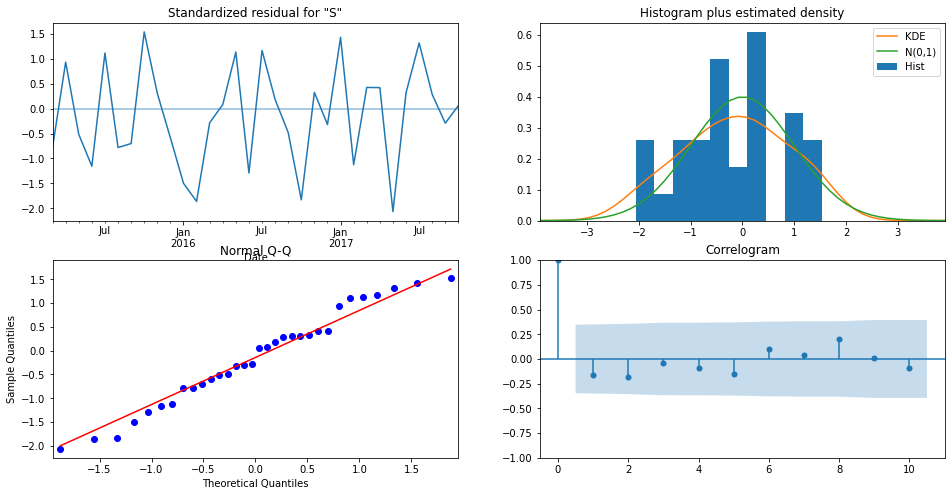

In [23]:
# to check for any unusual model behaviour, make model diagnostics and display the results
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

In [24]:
type(results)

statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper

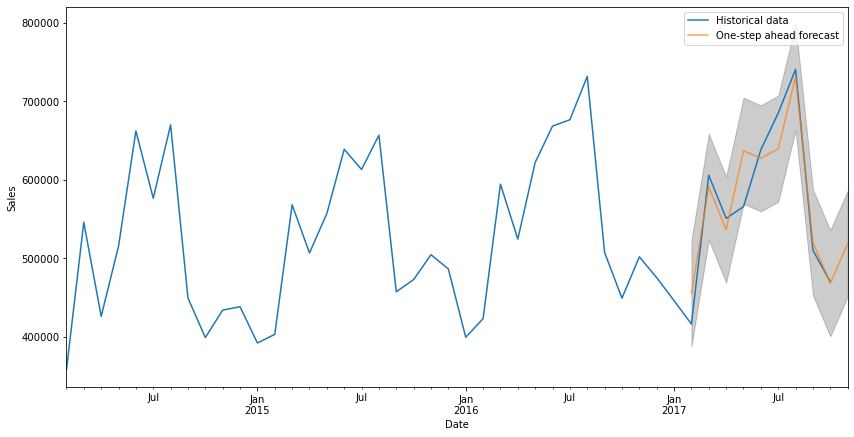

In [25]:
# to compare accuracy of model predictions, run comparizon of real data and predicted, 
# starting from '2017-02-01'
pred = results.get_prediction(start=pd.to_datetime('2017-02-01'), end=pd.to_datetime('2017-10-19'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='Historical data')
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

Acording to the plot illustration, model predictions goes very closely to the actual data, capturing seasonality of the sales.

In [26]:
# calculate Mean Squared Error for model forecasts and display the average of squarred of errors
y_pred = pred.predicted_mean
y_pred = y_pred [:-1]
y_true = y['2017-02-01':]
mse = ((y_pred - y_true) ** 2).mean()

In [27]:
print(f'The Mean Squared Error of model forecasts is {round(mse, 2)}')

The Mean Squared Error of model forecasts is 1042900036.19


In [28]:
print(f'The Root Mean Squared Error of model forecasts is {round(np.sqrt(mse), 2)}')

The Root Mean Squared Error of model forecasts is 32293.96


In [29]:
# calculate persentage error of our model and display the results
model_error = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'The model gives in average {round(model_error, 2)}% of errors in making forecasts comparing to actual data!')

The model gives in average 4.34% of errors in making forecasts comparing to actual data!


## Producing and visualizing forecasts for next 6 months

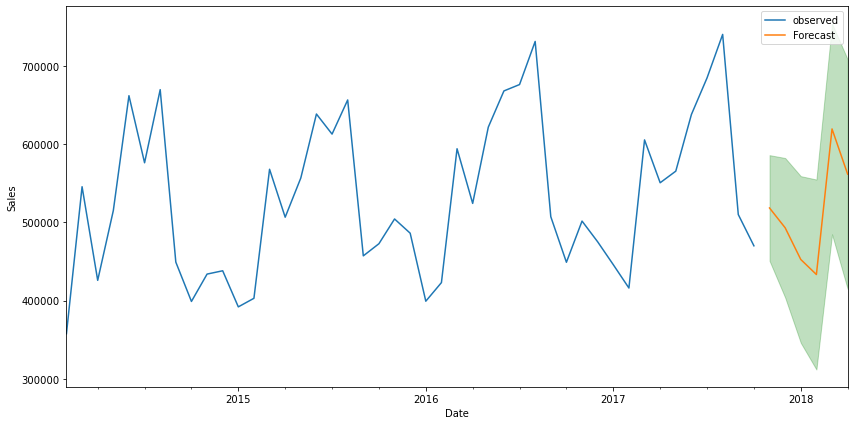

In [30]:
pred_uc =results.get_forecast(steps=6)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='g', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.legend()
plt.show()

## Display the forecasted data for next 6 months

In [31]:
# make predictions for next 6 months
pred_tbl = results.forecast(steps=6)

In [32]:
# display results of forecasts as table
pd.DataFrame({'Projected Date':pred_tbl.index, 'Sales':pred_tbl.values})

,Projected Date,Sales
0,2017-11-01,518383.794225
1,2017-12-01,493054.031488
2,2018-01-01,452488.502238
3,2018-02-01,433261.026184
4,2018-03-01,619513.399652
5,2018-04-01,561667.482921
